In [52]:
pip install tensorflow==2.0


Note: you may need to restart the kernel to use updated packages.


In [53]:
# if running in colab, this block chooses tf 2.0:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [54]:
# https://www.pyimagesearch.com/2017/NUM_CLASSES/11/image-classification-with-keras-and-deep-learning/
# https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/
# https://machinelearningmastery.com/save-load-keras-deep-learning-models/
#https://www.learnopencv.com/image-classification-using-convolutional-neural-networks-in-keras/

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
import sys
#import cv2
import matplotlib
from subprocess import check_output
import tensorflow as tf
import matplotlib.pyplot as plt
import math as m

from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical



In [55]:
tf.__version__

'2.0.0'

In [56]:
'''
import sys

sys.path.append('/content/drive/My Drive/Colab Notebooks/machine learning in imaging/final project')
'''

"\nimport sys\n\nsys.path.append('/content/drive/My Drive/Colab Notebooks/machine learning in imaging/final project')\n"

## uncomment it if we want to redownload the data

In [57]:
'''
import tensorflow_datasets as tfds
#dataset = tfds.image.mnist
# https://www.tensorflow.org/datasets/api_docs/python/tfds/core/DatasetBuilder

malaria_builder = tfds.builder("colorectal_histology")
malaria_info = malaria_builder.info
malaria_builder.download_and_prepare()
datasets = malaria_builder.as_dataset()
datasets
'''

'\nimport tensorflow_datasets as tfds\n#dataset = tfds.image.mnist\n# https://www.tensorflow.org/datasets/api_docs/python/tfds/core/DatasetBuilder\n\nmalaria_builder = tfds.builder("colorectal_histology")\nmalaria_info = malaria_builder.info\nmalaria_builder.download_and_prepare()\ndatasets = malaria_builder.as_dataset()\ndatasets\n'

In [62]:
from numpy import load

image_array = load('image_array_colorectal2.npy')


In [63]:
from numpy import load
#image_array = load('/content/drive/My Drive/Colab Notebooks/machine learning in imaging/final project/image_array_colorectal.npy')
label_array = load('label_array_colorectal2.npy')
image_array = image_array/255
# print the array
image_array.shape

(5000, 150, 150, 3)

In [64]:
image_array[1]

array([[[0.41568627, 0.18431373, 0.34117647],
        [0.50196078, 0.27058824, 0.42745098],
        [0.52941176, 0.28235294, 0.44705882],
        ...,
        [0.63137255, 0.34901961, 0.54509804],
        [0.52941176, 0.31764706, 0.51372549],
        [0.4745098 , 0.2627451 , 0.45882353]],

       [[0.35686275, 0.1372549 , 0.3254902 ],
        [0.45098039, 0.23137255, 0.41960784],
        [0.49411765, 0.24705882, 0.44705882],
        ...,
        [0.6       , 0.36470588, 0.55294118],
        [0.56078431, 0.3372549 , 0.5372549 ],
        [0.51764706, 0.29411765, 0.49411765]],

       [[0.27058824, 0.11764706, 0.27843137],
        [0.34117647, 0.18823529, 0.34901961],
        [0.46666667, 0.20392157, 0.40392157],
        ...,
        [0.57254902, 0.34509804, 0.54509804],
        [0.59607843, 0.37254902, 0.58039216],
        [0.55686275, 0.33333333, 0.54117647]],

       ...,

       [[0.90196078, 0.90980392, 0.89803922],
        [0.92156863, 0.92941176, 0.91764706],
        [0.92941176, 0

In [65]:
print(label_array.shape)
print(image_array.shape)

(5000,)
(5000, 150, 150, 3)


In [66]:
x_train, x_test, y_train, y_test = train_test_split( image_array, label_array, test_size=0.25, random_state=42)

In [69]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(3750, 150, 150, 3) (3750,)
(1250, 150, 150, 3) (1250,)


In [70]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

# some parameters

In [75]:
wavelength_ = .5e-3          # units are mm
optical_thickness_ = 20 * wavelength_

wavelength = tf.constant(wavelength_, dtype=tf.complex64)
optical_thickness = tf.constant(optical_thickness_, dtype=tf.complex64)

# RGB color filter

In [77]:
color_filter_tmp = np.ones([3,150,150])
color_filter_ = tf.Variable(color_filter_tmp,dtype=tf.float32,trainable=True,name='color_filter_')
#color_filter_ = tf.expand_dims(color_filter_, 0) # add extra axis for batch size


## Aperture

In [78]:

num_samples = 150
fxmax= 75
fx = np.linspace(-fxmax, fxmax,num_samples)
fy = fx
[fxx,fyy] = np.meshgrid(fx, fy)
# Take 2D fourier transform of sample


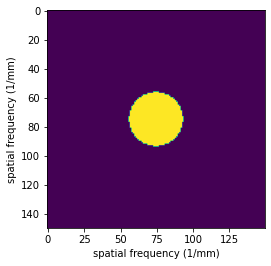

In [79]:
na = .25 * fxmax
lens_transfer_functiontmp = (np.sqrt(fxx**2+fyy**2))<na


plt.imshow(lens_transfer_functiontmp)
plt.xlabel('spatial frequency (1/mm)')
plt.ylabel('spatial frequency (1/mm)')
plt.show()

lens_transfer_function = tf.Variable(lens_transfer_functiontmp,dtype=tf.float32)

lens_transfer_function = tf.cast(lens_transfer_function,tf.complex64)


In [80]:
#aperture_phase = tf.Variable(tf.ones([150,150]),dtype=tf.float32,trainable=True,name='aperture_phase')
aperture_phase = tf.Variable(initial_value = tf.initializers.GlorotNormal()(shape=(150,150)),dtype=tf.float32,trainable=True,name='aperture_phase')


# physical layer RGB

In [87]:
#from PIL import Image
def physical_layer_RGB(x_batch):
  print('123123123')
  print('x_batch shape', x_batch.shape)

  sample = tf.cast(x_batch, tf.complex64)
  print('1111')

  print('2222')

  #### OPTICS #####

  sample = tf.transpose(sample, perm=[0,3,1,2])

  print('channel G sample 1')
  
  #tfplot.plot(plt.imshow,sample[1,1,:,:])
  ##ax.imshow(sample[1,1,:,:])  
  #tfplot.show()
  
  
  #plot_imshow(tf.cast((sample[1,1,:,:]),tf.float32))
  print('channel G sample 1 original')

  #plt.imshow(tf.cast((sample[1,1,:,:]),tf.float32))
  #plt.show()

  #FT_sample = tf.Variable(sample,dtype=tf.complex64,trainable=False)
  FT_sample = tf.signal.fft2d(sample)
  FT_sample_shift = tf.signal.fftshift(FT_sample,axes=(2,3))

  print('after color filter')
  color_filter_2 = tf.cast(color_filter_, tf.complex64)

  filtered_FT_sample  =tf.multiply(color_filter_2,FT_sample_shift) 
  #plt.imshow(tf.cast(filtered_FT_sample[1,1,:,:],tf.float32))
  #plt.show()
  
  aperture_phase2 = tf.cast(aperture_phase, tf.complex64)
  aperture = lens_transfer_function * tf.exp(1j * 2* m.pi* aperture_phase2)
  filtered_FT_sample  =tf.multiply(aperture,filtered_FT_sample) 

  print('after transfer function ')
  filtered_FT_sample  =tf.multiply(lens_transfer_function,filtered_FT_sample) 
  #plt.imshow(tf.cast(filtered_FT_sample[1,1,:,:],tf.float32))
  #plt.show()


  print('after ifft2d ')
  image = tf.signal.ifft2d(filtered_FT_sample)
  #plt.imshow(abs(image[1,1,:,:]))
  #plt.show()


  print('after repermutation :tf.transpose(image, perm=[0,2,3,1]) ')
  image = tf.transpose(image, perm=[0,2,3,1])
  #plt.imshow(abs(image[1,:,:,1]))
  #plt.show()

  image = tf.square(tf.abs(image)) #convert it to intensity
  #image = tf.square(((image) * tf.math.conj(image))) #convert it to intensity
  image = tf.cast(image, tf.float32)
  print('image shape after physical layer',image.shape)

  return image

# physical layer phase mask

In [88]:
def physical_layer_phase_mask(x_batch):
  
  x_batch = tf.cast(x_batch, tf.complex64)

  sample = x_batch


#### OPTICS #####
  sample = tf.transpose(sample, perm=[0,3,1,2])

  FT_sample  = tf.signal.fft2d(sample )
  FT_sample_shift = tf.signal.fftshift(FT_sample,axes=(2,3))

  #aperture_phase = tf.clip_by_value(aperture_phase, clip_value_min=0, clip_value_max=1) # [[1, 3, 3],[3, 3, 3]]

  aperture_phase2 = tf.cast(aperture_phase, tf.complex64)

  aperture = lens_transfer_function * tf.exp(1j * 2* m.pi* aperture_phase2)
  filtered_FT_sample  =tf.multiply(aperture, FT_sample_shift) 

  


#### IFFT  and form the image!!! #################
  image = tf.signal.ifft2d(filtered_FT_sample)
  image = tf.transpose(image, perm=[0,2,3,1])

  image = tf.square(tf.abs(image)) #convert it to intensity

  #image = tf.square(((image) * tf.math.conj(image))) #convert it to intensity
  image = tf.cast(image, tf.float32)
  

  return image

# alexnet

In [89]:
# https://www.google.com/search?q=alexnet&sxsrf=ALeKk03nxwjPnSPq77l41iACT4nuWtF0nw:1584470777490&source=lnms&tbm=isch&sa=X&ved=2ahUKEwiGl-XOlaLoAhXtT98KHVwTCIIQ_AUoAXoECA0QAw&biw=1280&bih=529#imgrc=j8y8gy88lYqI-M
#https://github.com/henrypowell87/AlexNet_TF2.0/blob/master/main.py


class Alexnet(tf.keras.Model):
  def __init__(self):
    super(Alexnet, self).__init__()
    self.conv_1 =    tf.keras.layers.Conv2D(filters=96, kernel_size=11, strides=4, padding='same', activation='relu')
    self.pool_1 =    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2),padding="valid")
    self.norm_1 =    tf.keras.layers.BatchNormalization()
    
    self.conv_2 =    tf.keras.layers.Conv2D(filters=256, kernel_size=5, strides=1, padding='same', activation='relu')
    self.pool_2 =    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2),padding="valid")
    self.norm_2 =    tf.keras.layers.BatchNormalization()

    self.conv_3 =    tf.keras.layers.Conv2D(filters=384, kernel_size=3, strides=1, padding='valid', activation='relu')
    self.norm_3 =    tf.keras.layers.BatchNormalization()

    self.conv_4 =    tf.keras.layers.Conv2D(filters=384, kernel_size=3, strides=1, padding='valid', activation='relu')
    self.norm_4 =    tf.keras.layers.BatchNormalization()


    self.conv_5 =    tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu')
    self.pool_5 =    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2),padding="valid")
    self.norm_5 =    tf.keras.layers.BatchNormalization()




    #self.block_5 =    tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu')
    self.flat = tf.keras.layers.Flatten()

    self.dense_6 = tf.keras.layers.Dense(units=4096, activation='relu')
    self.drop_6 = tf.keras.layers.Dropout(rate=0.4)
    self.norm_6 =    tf.keras.layers.BatchNormalization()

    self.dense_7 = tf.keras.layers.Dense(units=4096, activation='relu')
    self.drop_7 = tf.keras.layers.Dropout(rate=0.4)
    self.norm_7 =    tf.keras.layers.BatchNormalization()

    self.dense_8 = tf.keras.layers.Dense(units=1000, activation='relu')
    self.drop_8 = tf.keras.layers.Dropout(rate=0.4)
    self.norm_8 =    tf.keras.layers.BatchNormalization()

    self.classifier =  tf.keras.layers.Dense(8, activation='softmax')  # length-10 output for classification


  def call(self, x):
    # ...

    x= self.conv_1(x)
    x= self.pool_1(x)
    x= self.norm_1(x)
    
    x= self.conv_2(x)
    x= self.pool_2(x)
    x= self.norm_2(x)

    x= self.conv_3(x)
    x= self.norm_3(x)

    x= self.conv_4(x)
    x= self.norm_4(x)


    x= self.conv_5(x)
    x= self.pool_5(x)
    x= self.norm_5(x)




    #self.block_5 =    tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu')
    x= self.flat(x)

    x= self.dense_6(x)  
    x= self.drop_6(x)  
    x= self.norm_6(x)   

    x= self.dense_7(x)  
    x= self.drop_7(x)  
    x= self.norm_7(x)   

    x= self.dense_8(x) 
    x= self.drop_8(x)  
    x= self.norm_8(x)    

    x = self.classifier(x) 

    return x



alexnet = Alexnet()

# VGG16

In [90]:
# https://www.kaggle.com/cdeotte/how-to-choose-cnn-architecture-mnist
# best model classify mnist? 784 - [32C3-32C3-32C5S2] - [64C3-64C3-64C5S2] - 128 - 10


class VGG16(tf.keras.Model):
  def __init__(self):
    super(VGG16, self).__init__()

    self.conv_1 =    tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu')
    self.conv_12 =    tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu')
    self.pool_1 =    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2),padding="valid")
    

    self.conv_2 =    tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu')
    self.conv_22 =    tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu')
    self.pool_2 =    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2),padding="valid")


    self.conv_3 =    tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu')
    self.conv_32 =    tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu')
    self.conv_33 =    tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu')
    self.pool_3 =    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2),padding="valid")



    self.conv_4 =    tf.keras.layers.Conv2D(filters=512, kernel_size=3, strides=1, padding='same', activation='relu')
    self.conv_42 =    tf.keras.layers.Conv2D(filters=512, kernel_size=3, strides=1, padding='same', activation='relu')
    self.conv_43 =    tf.keras.layers.Conv2D(filters=512, kernel_size=3, strides=1, padding='same', activation='relu')
    self.pool_4 =    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2),padding="valid")



    self.conv_5 =    tf.keras.layers.Conv2D(filters=512, kernel_size=3, strides=1, padding='same', activation='relu')
    self.conv_52 =    tf.keras.layers.Conv2D(filters=512, kernel_size=3, strides=1, padding='same', activation='relu')
    self.conv_53 =    tf.keras.layers.Conv2D(filters=512, kernel_size=3, strides=1, padding='same', activation='relu')
    self.pool_5 =    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2),padding="valid")



######################## dense ######################################

    self.flat = tf.keras.layers.Flatten()

    self.dense_6 = tf.keras.layers.Dense(units=4096, activation='relu')
    self.drop_6 = tf.keras.layers.Dropout(rate=0.4)
    self.norm_6 =    tf.keras.layers.BatchNormalization()

    self.dense_7 = tf.keras.layers.Dense(units=4096, activation='relu')
    self.drop_7 = tf.keras.layers.Dropout(rate=0.4)
    self.norm_7 =    tf.keras.layers.BatchNormalization()

    self.dense_8= tf.keras.layers.Dense(units=4096, activation='relu')
    self.drop_8 = tf.keras.layers.Dropout(rate=0.4)
    self.norm_8 = tf.keras.layers.BatchNormalization()

    self.classifier =  tf.keras.layers.Dense(8, activation='softmax')  # length-10 output for classification


  def call(self, x):
    
    x= self.conv_1(x)
    x= self.conv_12(x)
    x= self.pool_1(x)
    
    x= self.conv_2(x)
    x= self.conv_22(x)
    x= self.pool_2(x)
    

    x= self.conv_3(x)
    x= self.conv_32(x)
    x= self.conv_32(x)
    x= self.pool_3(x)


    x= self.conv_4(x)
    x= self.conv_42(x)
    x= self.conv_42(x)
    x= self.pool_4(x)


    x= self.conv_5(x)
    x= self.conv_52(x)
    x= self.conv_53(x)
    x= self.pool_5(x)
            
  ######## flatten #################

    x= self.flat(x)

    x= self.dense_6(x)  
    x= self.drop_6(x)  
    x= self.norm_6(x)   

    x= self.dense_7(x)  
    x= self.drop_7(x)  
    x= self.norm_7(x)   

    x= self.dense_8(x) 
    x= self.drop_8(x)  
    x= self.norm_8(x)    

    x = self.classifier(x) 

    #x += input_tensor
    return x



vgg16 = VGG16()

# forward model 

In [91]:
def forward_model_RGB(x_batch):

  physical_out = physical_layer_RGB(x_batch)
  return alexnet(physical_out)


In [92]:
def forward_model_phase_mask(x_batch):
  physical_out = physical_layer_phase_mask(x_batch)
  return alexnet(physical_out)

# define loss and train test step 

In [93]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

optimizer = tf.keras.optimizers.Adam()

In [94]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [95]:
@tf.function
def train_step(images, labels):

  ## add physical layer in here?????
  #### i fix the physical layer for now, just to make sure the cnn is running
  #print('aaa')

  #####
  with tf.GradientTape() as tape:    
    print('bbb')
    #tape.watch(input_illumination_phase)
    tape.watch(aperture_phase)
    #tape.watch(color_filter_)
    #predictions = model(images)
    print('ccc')

    #predictions = forward_model(images,input_illumination_phase,aperture_phase)
    predictions = forward_model_phase_mask(images)
    #predictions = forward_model_RGB(images)
    
    print('ddd')
  
    #predictions = forward_model_RGB(images,aperture_phase)
    #predictions = model(images)
    loss = loss_object(labels, predictions)
    #gradients_aperture = tf.gradients(loss, aperture_phase)
    print('ggg')


  gradients = tape.gradient(loss, alexnet.trainable_variables +[aperture_phase] )
  optimizer.apply_gradients(zip(gradients, alexnet.trainable_variables+ [aperture_phase]))
  #gradients = tape.gradient(loss,alexnet.trainable_variables + [ aperture_phase] )
  #optimizer.apply_gradients(zip(gradients,alexnet.trainable_variables+[ aperture_phase]))
  
  print('fff')
  #optimizer.apply_gradients(gradients_input_illum, input_illumination_phase)

  train_loss(loss)
  train_accuracy(labels, predictions)
  

In [96]:
@tf.function
def test_step(images, labels):
###  
##
  print('test step')
  #predictions = forward_model(images,input_illumination,aperture)
  #predictions = forward_model_RGB(images)

  predictions = forward_model_phase_mask(images)
  #predictions = model(images)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)
  print(test_accuracy.result())
  #print(test_accuracy.result().eval())
  return predictions

# training!!!!!!! gogogo


In [97]:
EPOCHS = 10
train_acc_list = []
test_acc_list = []
train_loss_list = []
test_loss_list = []

predictions_arr = np.array([])
label_arr = np.array([])


for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()
  i = 0
  for images, labels in train_ds:
    i = i+1 # total 1875 batches for training data
    #print('i',i)
    images = images.numpy()
    labels = labels.numpy()
    #images = tf.cast(images, tf.float32)
    #print(images)
    train_step(images, labels)
    if i%20 == 0:
      template_train = 'Epoch {}, Total iteration {}, Train Loss: {}, Train Accuracy: {}'
      print(template_train.format(epoch+1, i, train_loss.result(), train_accuracy.result()*100))
      ## monitor the illuminace phase and aperture phase
  t = 0
  for test_images, test_labels in test_ds:
    predictions =  test_step(test_images, test_labels)

    if (epoch == 9):
  # only biuld the confusion matrix by the last epoch
      predictions_arr = np.append(predictions_arr , predictions)
      label_arr = np.append(label_arr, test_labels)
      print('label_arr.shape',label_arr.shape)
    t = t + 1 
    #print('t',t)
    if t%20 == 0:
      template_test = 'Epoch {}, Total iteration {}, Test Loss: {}, Test Accuracy: {}'
      print(template_test.format(epoch+1, t, test_loss.result(), test_accuracy.result()*100))
  template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
  print('predictions_arr',predictions_arr)
  print('label_arr',label_arr)
  print(template.format(epoch+1,
                        train_loss.result(),
                        train_accuracy.result()*100,
                        test_loss.result(),
                        test_accuracy.result()*100))
  
  
  test_acc_list.append(test_accuracy.result()*100)
  train_acc_list.append(train_accuracy.result()*100)
  test_loss_list.append(test_loss.result())
  train_loss_list.append(train_loss.result())

train_loss_arr = np.array(train_loss_list)
test_loss_arr = np.array(test_loss_list)
print('train_loss_arr',train_loss_arr)
print('test_loss_arr',test_loss_arr)

train_acc_arr = np.array(train_acc_list)
test_acc_arr = np.array(test_acc_list)
print('train_acc_arr',train_acc_arr)
print('test_acc_arr',test_acc_arr)

bbb
ccc
ddd
ggg
fff
bbb
ccc
ddd
ggg
fff
Epoch 1, Total iteration 20, Train Loss: 2.0556304454803467, Train Accuracy: 22.5
Epoch 1, Total iteration 40, Train Loss: 1.7849299907684326, Train Accuracy: 27.734375
Epoch 1, Total iteration 60, Train Loss: 1.6380354166030884, Train Accuracy: 30.416667938232422
Epoch 1, Total iteration 80, Train Loss: 1.5648236274719238, Train Accuracy: 32.1484375
Epoch 1, Total iteration 100, Train Loss: 1.519595742225647, Train Accuracy: 34.1875
bbb
ccc
ddd
ggg
fff
test step
Tensor("Identity_2:0", shape=(), dtype=float32)
Epoch 1, Total iteration 20, Test Loss: 1.6565043926239014, Test Accuracy: 21.40625
test step
Tensor("Identity_2:0", shape=(), dtype=float32)
Epoch 1, Total iteration 40, Test Loss: 1.6343023777008057, Test Accuracy: 22.31999969482422
predictions_arr []
label_arr []
Epoch 1, Loss: 1.4768261909484863, Accuracy: 35.36000061035156, Test Loss: 1.6343023777008057, Test Accuracy: 22.31999969482422
Epoch 2, Total iteration 20, Train Loss: 1.375682

label_arr.shape (704,)
label_arr.shape (736,)
label_arr.shape (768,)
label_arr.shape (800,)
label_arr.shape (832,)
label_arr.shape (864,)
label_arr.shape (896,)
label_arr.shape (928,)
label_arr.shape (960,)
label_arr.shape (992,)
label_arr.shape (1024,)
label_arr.shape (1056,)
label_arr.shape (1088,)
label_arr.shape (1120,)
label_arr.shape (1152,)
label_arr.shape (1184,)
label_arr.shape (1216,)
label_arr.shape (1248,)
label_arr.shape (1250,)
Epoch 10, Total iteration 40, Test Loss: 1.0853089094161987, Test Accuracy: 52.0
predictions_arr [4.86682547e-05 6.58564508e-01 1.05827771e-01 ... 2.48536631e-03
 6.31285226e-03 4.91832092e-04]
label_arr [1. 5. 0. ... 3. 6. 1.]
Epoch 10, Loss: 0.9453462362289429, Accuracy: 54.720001220703125, Test Loss: 1.0853089094161987, Test Accuracy: 52.0
train_loss_arr [1.4768262  1.2174121  1.0641541  1.0160685  1.0239985  0.93034524
 0.90822613 1.894398   1.047116   0.94534624]
test_loss_arr [1.6343024  1.3051945  1.1888597  0.98395526 0.9949837  0.96524847


In [98]:
lens = predictions_arr.shape[0]
print(lens)
predictions_arr = np.reshape(predictions_arr, (int(lens/8),8))
print(predictions_arr.shape)

10000
(1250, 8)


In [99]:

predictions_arr_real = np.zeros(predictions_arr.shape[0])
#for i in range(predictions_arr2.shape[0]):
predictions_arr_real = np.argmax(predictions_arr,axis = 1)

print(predictions_arr_real.shape)
print(predictions_arr_real)

(1250,)
[1 5 3 ... 0 7 4]


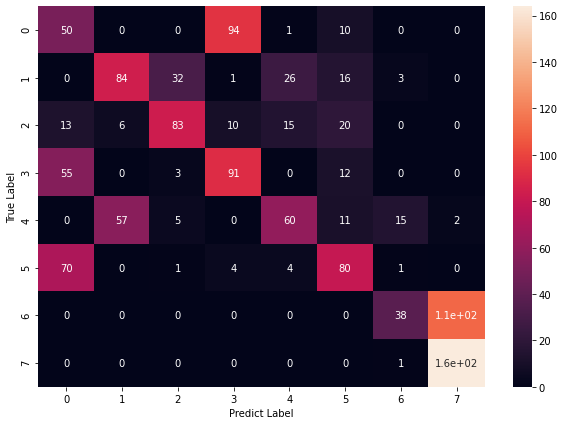

In [108]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(label_arr, predictions_arr_real)
df_cm = pd.DataFrame(cm, index = [i for i in "01234567"],
                  columns = [i for i in "01234567"])
plt.figure(figsize = (10,7))

ax = sns.heatmap(df_cm, annot=True)
ax.set(xlabel="Predict Label", ylabel = "True Label")
plt.show()